In [23]:
#Import libraries 
import os
import cv2
import numpy as np
from skimage.io import imread
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

Start Image and labels reading process 


In [24]:
def ReadImagesLabels(machineproject_path, str):
    # Construct the paths to the images and labels folders
    images_folder = os.path.join(machineproject_path, str, "images")
    labels_folder = os.path.join(machineproject_path, str, "labels")

    # Initialize lists for images and labels and hog features
    image_list = []
    label_list = []
    
    # Iterate through label files and check the conditions
    for label_file in os.listdir(labels_folder):
        label_file_path = os.path.join(labels_folder, label_file)

        # Check if the file is not empty
        if os.path.getsize(label_file_path) > 0:
            with open(label_file_path, "r") as label_file:
                # Read the first character of the label
                first_letter = label_file.read(1)

                # Check conditions based on the first letter
                if first_letter == '2':
                    label_list.append(0)  # Encoding 'Fresh' as 0
                elif first_letter == '3':
                    label_list.append(1)  # Encoding 'Rotten' as 1
                else:
                    label_list.append(-1)  # Encoding 'Unknown' as -1
                

            # Append the image filename to the image list
            image_filename = label_file.name.replace(".txt", ".jpg")  # Assuming image files have .jpg extension
            image_path = os.path.join(images_folder, image_filename)
            image_list.append(image_path)


        else:
            label_list.append(-1) 

    return image_list, label_list

Start extracte features from images using SIFT algorithm 


In [25]:
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    features = []

    for label_file_path in images:
        try:
            # Extract the image filename from the label file path
            image_filename = os.path.basename(label_file_path).replace(".txt", ".jpg")

            # Correct the folder name to "images" in the path
            corrected_image_path = label_file_path.replace("labels", "images").replace(image_filename, "")

            # Remove any extra "images" folder in the path
            corrected_image_path = corrected_image_path.replace("\\images", "\\images")

            # Construct the correct path to the image in the "images" folder
            image_path = os.path.join(corrected_image_path, image_filename)

            #read the img in grayscale
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Check if the image is loaded successfully
            if img is None:
                print(f"Error loading image: {image_path}")
                features.append(np.array([]))
                continue

            # Check if the image is not empty
            if img.size == 0:
                print(f"Empty image: {image_path}")
                features.append(np.array([]))
                continue

            # Detect keypoints and compute descriptors using SIFT
            keypoints, descriptors = sift.detectAndCompute(img, None)

            # Check if keypoints and descriptors are obtained
            if descriptors is not None and descriptors.shape[0] > 0:
                # Pad or truncate descriptors to a fixed size (128)
                descriptor_size = 128
                # If the number of descriptors is less than the desired size
                # Pad the descriptors array with zeros to match the desired size
                if descriptors.shape[0] < descriptor_size:
                    descriptors = np.pad(descriptors, ((0, descriptor_size - descriptors.shape[0]), (0, 0)))
                # If the number of descriptors is greater than the desired size
                # delete from the descriptors array to keep only the desired number of descriptors
                elif descriptors.shape[0] > descriptor_size:
                    descriptors = descriptors[:descriptor_size, :]
                # Flatten the descriptors and add them to the features list
                features.append(descriptors.flatten())
            else:
                print(f"No keypoints or descriptors found for image: {image_path}")
                features.append(np.zeros(128))  # Add zeros as a placeholder for images with no descriptors

        except Exception as e:
            print(f"Error processing image: {image_path}, Exception: {str(e)}")
            features.append(np.zeros(128))  # Add zeros as a placeholder for images with processing errors

    return np.array(features)

Start removing extra / unknown / empty labels and images 


In [26]:
#Function to remove unknown images with it's labels 
      
def removeunknown(image_list, label_list):
    indices_to_remove = [i for i, label in enumerate(label_list) if label == -1]

    # Remove elements from the end to avoid index errors
    for index in reversed(indices_to_remove):
        if index < len(image_list):
            label_list.pop(index)
            image_list.pop(index)

In [27]:
machineproject_path = 'E:\\.college\\ML_Project\\TomatoDetection' 

In [28]:
#read the train images with labels 
xtrain, ytrain = ReadImagesLabels(machineproject_path, 'train')
removeunknown(xtrain, ytrain)
y_train_encoded = np.array(ytrain)

In [29]:
#read the test images with labels
xtest, ytest = ReadImagesLabels(machineproject_path, 'test')
removeunknown(xtest,ytest)
y_test_encoded = np.array(ytest)

In [30]:
#print the results after removing unknown and empty data
"""
for image, label in zip(xtrain, ytrain):
    print(f"Image: {image}, Label: {label}")
"""

'\nfor image, label in zip(xtrain, ytrain):\n    print(f"Image: {image}, Label: {label}")\n'

In [31]:
#implement sift algorithm to extract features from images 
image_features = extract_sift_features(xtrain)
test_features = extract_sift_features(xtest)

In [32]:
#print results after sift algorithm
"""for image, label, feature in zip(xtrain, ytrain, image_features):
    print(f"Image: {image}, Label: {label}, Feature: {feature}")"""

'for image, label, feature in zip(xtrain, ytrain, image_features):\n    print(f"Image: {image}, Label: {label}, Feature: {feature}")'

Start Scaling process 


In [33]:
# Scaling Features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(image_features)
X_test_scaled = scaler.transform(test_features)

In [34]:
# Check if the size of x_train != size of y_train then drop extra label 
if X_train_scaled.shape[0] != y_train_encoded.shape[0]:
    y_train_encoded = y_train_encoded[:-1]

# Check the shape of X_train_scaled and y_train_encoded
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of y_train_encoded:", y_train_encoded.shape)

Shape of X_train_scaled: (5460, 16384)
Shape of y_train_encoded: (5460,)


In [35]:
# Check if the size of x_test != size of y_test then drop extra label 
if X_test_scaled.shape[0] != y_test_encoded.shape[0]:
    y_test_encoded = y_test_encoded[:-1]

# Check the shape of X_test_scaled and y_test_encoded
print("Shape of X_test_scaled:",X_test_scaled.shape)
print("Shape of y_test_encoded:", y_test_encoded.shape)

Shape of X_test_scaled: (1104, 16384)
Shape of y_test_encoded: (1104,)


Start LogisticRegression 


In [36]:
# Train the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)

try:
    model.fit(X_train_scaled, y_train_encoded)
except ValueError as e:
    print("Error:", e)

In [37]:
# Predict the target values for the training / testing /val set using the trained model
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

In [38]:
# For training set
if len(y_pred_train) != len(ytrain):
    ytrain = ytrain[:-1]  # Adjust the length of ytrain

# For testing set
if len(y_pred_test) != len(ytest):
    ytest = ytest[:-1]  # Adjust the length of ytest


Start Evaluation of the model


In [39]:
#Evaluate the model 
accuracy_train = accuracy_score(ytrain, y_pred_train)
accuracy_test = accuracy_score(ytest, y_pred_test)

print(f"Accuracy on Training Set: {accuracy_train}")
print(f"Accuracy on Testing Set: {accuracy_test}")

Accuracy on Training Set: 1.0
Accuracy on Testing Set: 0.5244565217391305


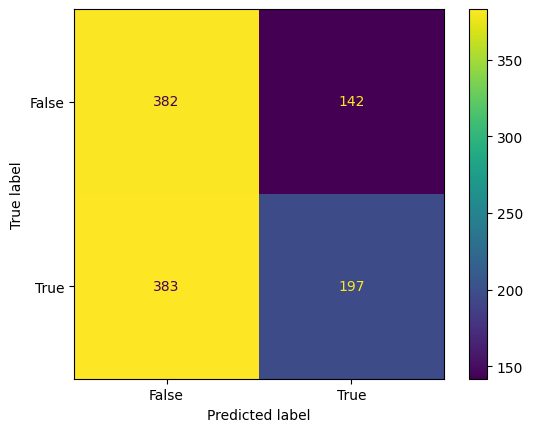

In [40]:
confusion_matrix = metrics.confusion_matrix(ytest, y_pred_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

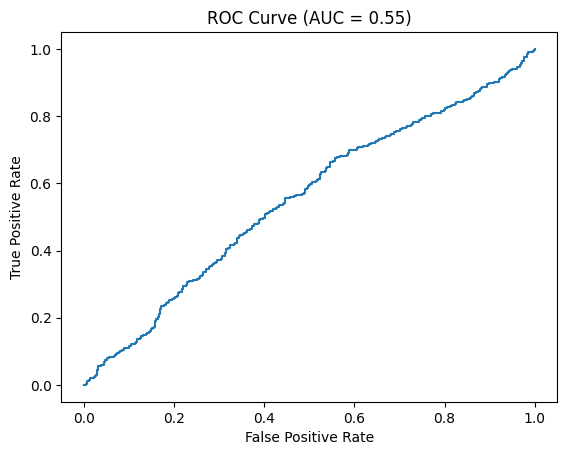

In [41]:
y_test_prob = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(ytest, y_test_prob)
auc_score = roc_auc_score(ytest, y_test_prob)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.show()